In [94]:
import matplotlib.pyplot as plt
import pennylane as qml

from pennylane import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import pandas as pd
import sys
sys.path.append("../")
from qmg.utils import MoleculeQuantumStateGenerator

num_heavy_atom = 2
data_path = f"../dataset/chemical_space/effective_{num_heavy_atom}.csv"
data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=16)
data = pd.read_csv(data_path)

# Quantum variables
n_a_qubits = 1  # Number of ancillary qubits / N_A
n_qubits = data_generator.n_qubits # + n_a_qubits  # Total number of qubits / N
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 1  # Number of subgenerators for the patch method / N_G
sample_num = 2000 # Number of sampled molecules for validating the training
# data_reuploading = False

dev = qml.device("lightning.qubit", wires=n_qubits) # Quantum simulator
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Enable CUDA device if available
device = torch.device("cpu")
print(device)

valid_state_mask = data_generator.generate_valid_mask(data)
valid_state_mask = torch.Tensor(valid_state_mask).to(device)


cpu


In [96]:
print(set(data["smiles"]))

{'CO', 'NN', 'CN', 'C=N', 'N=N', 'C=C', 'C#N', 'OO', 'O=O', 'C=O', 'N=O', 'O', 'C#C', 'N#N', 'NO', 'C', 'CC', 'N'}


In [83]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, weights, data_reuploading):
    weights = weights.reshape(q_depth, n_qubits * 3)
    for i in range(q_depth):
        if data_reuploading:
            for j in range(n_qubits):
                qml.RY(noise[j], wires=j)
        else:
            if i == 0:
                for j in range(n_qubits):
                    qml.RY(noise[j], wires=j)
        # Parameterised layer
        for y in range(n_qubits):
            qml.RZ(weights[i][3*y], wires=y)
            qml.RX(weights[i][3*y+1], wires=y)
            qml.RY(weights[i][3*y+2], wires=y)
        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CNOT(wires=[y, y + 1])
        else:
            qml.CNOT(wires=[y+1, 0])
    return qml.probs(wires=list(range(n_qubits)))

def binary_tensor_to_string(tensor):
    flat_tensor = tensor.view(-1).tolist()
    binary_string = ''.join(map(str, flat_tensor))
    return binary_string

def calc_validity_and_uniqueness(smiles_list):
    valid_smiles_list = [i for i in smiles_list if i is not None]
    return len(valid_smiles_list) / len(smiles_list), len(set(valid_smiles_list)) / len(smiles_list)

class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""
    def __init__(self, n_generators, valid_state_mask, q_delta=1, temperature=5, data_reuploading=False):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
            temperature (float, optional): parameter adjusting the output probability distribution.
            data_reuploading (bool): whether to use the data reuploading technique.
        """
        super().__init__()
        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits * 3), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators
        self.valid_state_mask = valid_state_mask
        self.noise_to_probability_linear_layer = nn.Linear(n_qubits, 2**n_qubits)
        self.softmax_layer = nn.Softmax(dim=1)
        self.temperature = temperature
        self.data_reuploading = data_reuploading
        for param in self.noise_to_probability_linear_layer.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** n_qubits # 2 ** (n_qubits - n_a_qubits)
        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        outputs = torch.Tensor(x.size(0), 0).to(device)
        # Iterate over all sub-generators
        for params in self.q_params:
            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = quantum_circuit(elem, params, self.data_reuploading).float().unsqueeze(0) # partial_measure
                patches = torch.cat((patches, q_out))
            # Each batch of patches is concatenated with each other to create a batch of images
            outputs = torch.cat((outputs, patches), 1)

        # converted input noise
        converted_x = self.noise_to_probability_linear_layer(x) * self.temperature# - 10 * (1 - self.valid_state_mask) 
        # converted_x = self.softmax_layer(converted_x)
        return outputs, converted_x
    
    def random_sample(self, sample_num, fixed_noise=False):
        weights = torch.tensor([])
        state_dict = self.state_dict()
        for name, param in state_dict.items():
            if name in ["noise_to_probability_linear_layer.weight", "noise_to_probability_linear_layer.bias"]:
                continue
            weights = torch.cat([weights, param.data])
        if fixed_noise:
            dev_sample = qml.device("default.qubit", wires=n_qubits, shots=sample_num)
        else:
            dev_sample = qml.device("default.qubit", wires=n_qubits, shots=1)
        @qml.qnode(dev_sample)
        def quantum_circuit_sample(noise, weights, data_reuploading):
            weights = weights.reshape(q_depth, n_qubits * 3)
            for i in range(q_depth):
                if data_reuploading:
                    for j in range(n_qubits):
                        qml.RY(noise[j], wires=j)
                else:
                    if i == 0:
                        for j in range(n_qubits):
                            qml.RY(noise[j], wires=j)
                # Parameterised layer
                for y in range(n_qubits):
                    qml.RZ(weights[i][3*y], wires=y)
                    qml.RX(weights[i][3*y+1], wires=y)
                    qml.RY(weights[i][3*y+2], wires=y)
                # Control Z gates
                for y in range(n_qubits - 1):
                    qml.CNOT(wires=[y, y + 1])
                else:
                    qml.CNOT(wires=[y+1, 0])
            return qml.sample()
        
        
        if fixed_noise:
            noise = torch.rand(n_qubits, device=device) * np.pi / 2
            sampled_quantum_states = quantum_circuit_sample(noise, weights, self.data_reuploading) # 2-dimensional torch.tensor
        else:
            sampled_quantum_states = []
            for i in range(sample_num):
                noise = torch.rand(n_qubits, device=device) * np.pi / 2
                sampled_quantum_states.append(quantum_circuit_sample(noise, weights, self.data_reuploading))

        sampled_quantum_states = [binary_tensor_to_string(qs) for qs in sampled_quantum_states]
        smiles_list = []
        for q in sampled_quantum_states:
            smiles_list.append(data_generator.QuantumStateToSmiles(q))
        return smiles_list

In [101]:
def plot_two_heavy_atoms_system(results: dict):
    keys = ['CO', 'NN', 'CN', 'C=N', 'N=N', 'C=C', 'C#N', 'OO', 'O=O', 'C=O', 'N=O', 'O', 'C#C', 'N#N', 'NO', 'C', 'CC', 'N', "None"]
    counts = [results.get(key, 0) for key in keys]
    total = sum(counts)
    counts = [c/total for c in counts]

    # 畫直方圖
    plt.figure(figsize=(5, 3))
    plt.bar(keys, counts, color='blue')
    plt.xlabel('Keys')
    plt.ylabel('Probability')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

sampling 2000 molecules, validity: 94.55%, uniqueness: 1.2%.


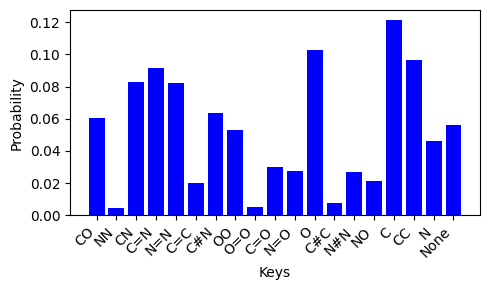

sampling 2000 molecules, validity: 90.14999999999999%, uniqueness: 1.25%.


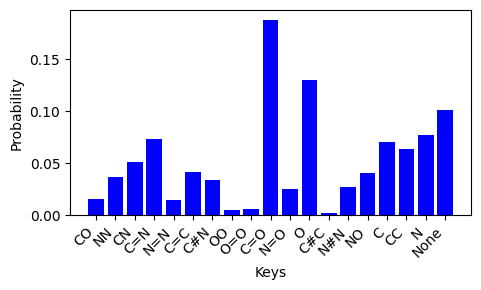

sampling 2000 molecules, validity: 91.4%, uniqueness: 1.2%.


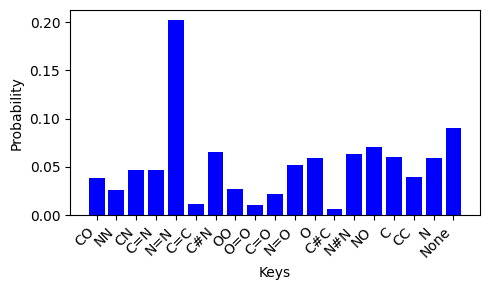

sampling 2000 molecules, validity: 89.8%, uniqueness: 1.25%.


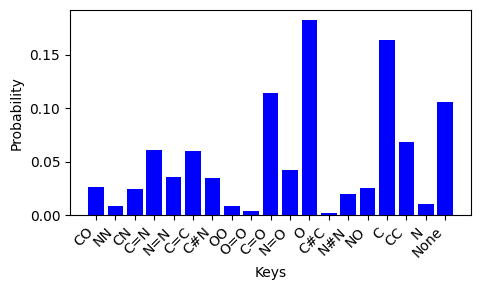

sampling 2000 molecules, validity: 90.75%, uniqueness: 1.2%.


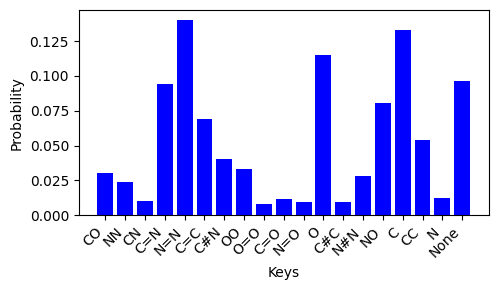

In [113]:
from collections import Counter
sample_num = 2000

generator = PatchQuantumGenerator(n_generators, valid_state_mask)
# 讀取模型參數
generator.load_state_dict(torch.load('models_5_sverage_difference/heavy_atoms_2/generator_80_steps.pt')) # best_generator
generator.eval()  # 設定模型為評估模式（如需要）
for _ in range(5):
    sample_smiles_list = generator.random_sample(sample_num=sample_num, fixed_noise=True)
    # print(Counter(sample_smiles_list))
    validity, uniqueness = calc_validity_and_uniqueness(sample_smiles_list)
    print(f"sampling {sample_num} molecules, validity: {validity*100}%, uniqueness: {uniqueness*100}%.")
    results = dict(Counter(sample_smiles_list))
    results['None']= results.pop(None)
    plot_two_heavy_atoms_system(results)


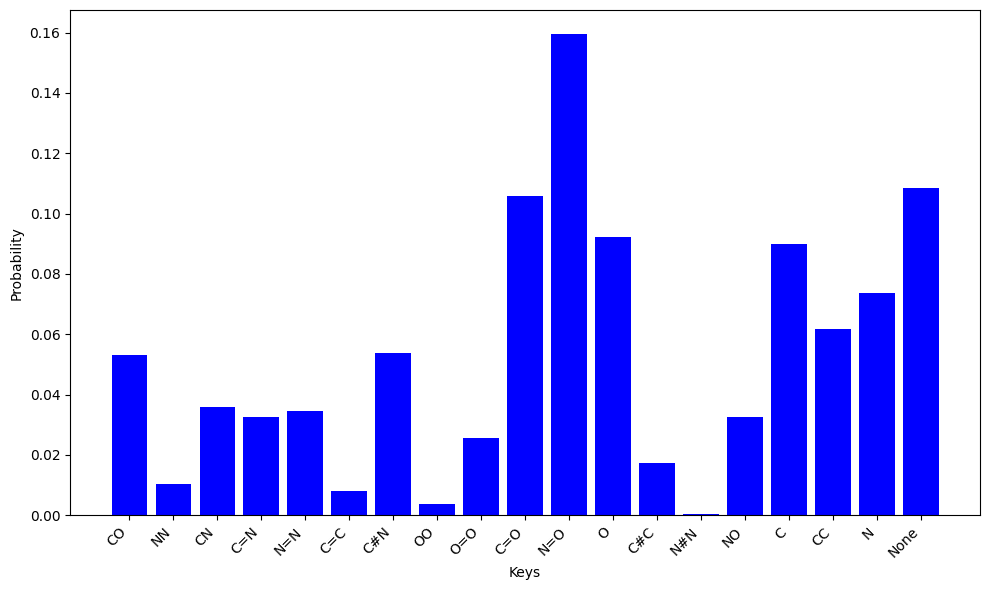

In [98]:



results = dict(Counter(sample_smiles_list))
results['None']= results.pop(None)
plot_two_heavy_atoms_system(results)

In [92]:
dict(Counter(sample_smiles_list)).keys()

dict_keys(['C.N', 'NN', 'CO', 'C=O', 'N=O', 'O=O', 'C=N', 'N', 'O', 'CC', 'C.O', None, 'C#N', 'C', 'CN', 'NO', 'N=N', 'O.O', '', 'C#C', 'N.O', 'C=C', 'N.N', 'OO', 'N#N', 'C.C'])